These tutorials are licensed by [Bernard Koch](http://www.github.com/kochbj) under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

# Tutorial 1: Introduction to Deep Learning for Causal Inference on Observables

The following tutorials are a gentle introduction to building deep learning models for causal inference using the selection on observables identification strategy. In particular, these model are designed to estimate the  average treatment effect (ATE) and the conditional average treatment effect (CATE). The ATE is defined as:

$$ATE =\mathbb{E}[Y(1)-Y(0)]$$

where $Y(1)$ and $Y(0)$ are the potential outcomes had the unit received or not received the treatment, respectively. The CATE is defined as,

$$CATE =\mathbb{E}[Y(1)-Y(0)|X=x]$$

where $X$ is the set of selected, observable covariates, and $x \in X$.

Because selection on observables is a simple identification strategy, these estimators are simple neural networks. This tutorial is thus also a gentle introduction to writing models in TensorFlow, and getting started coding deep learning models.

**These tutorials are for you if:**

1. You want a quick and dirty introduction to DL + Selection on Observables literature with minimal math, or...

2. You want a gentle introduction to writing  and training custom models in Tensorflow 2 and...

3. You have a basic familiarity with causal inference and...

4. You have a basic familiarity with Python and object oriented programming.

## Why use deep learning for causal inference?

1. Appropriately built neural network models are among the **lowest bias** estimators in our statistical arsenal.

2. For similar reasons, the complex response surfaces learned by neural networks make them well-suited for estimating **heterogeneous treatment effects**.

4. Most excitingly, deep learning has the ability to allow us to control for confounding found in **complex data types like images, text, and networks**.

3. Although most of these models don't make theoretical guarantees, representation learning **might be more robust to empirical violations of overlap** than simpler adjustment strategies.

5. Although most of these models don't make theoretical guarantees, representation learning **might be more robust to bias induced by including instruments**  in your conditioning covariates.

One more point: even if we cannot formally satisfy causal inference assumptions, these architectures are still very useful for **creating interpretable ML models** where we can isolate the contributions of specific covariates to predicting the outcome.

## Notation
**Causal identification**

- Observed covariates/features: $X$

- Potential outcomes: $Y(0)$ and $Y(1)$

- Treatment: $T$

- Average Treatment Effect: $ATE =\mathbb{E}[Y(1)-Y(0)]$

- Conditional Average Treatment Effect: $CATE =\mathbb{E}[Y(1)-Y(0)|X=x]$

**Deep learning estimation**

- Predicted outcomes: $\hat{Y}(0)$ and $\hat{Y}(1)$

- Outcome modeling functions: $\hat{Y}(T)=h(X,T)$

- Representation functions: $\Phi(X)$ (producing representations $\phi$)

- Loss functions: $\mathcal{L}(true,predicted)$, with the mean squared error abbreviated $MSE$ and binary cross-entropy as $BCE$

- Estimated CATE: $\hat{CATE}=(1-2t)(\hat{{y}}(1-t)-\hat{y}(t))$

- Estimated ATE: $\hat{ATE}=\frac{1}{n}\sum_{i=1}^n\hat{CATE_i}$


## Standard assumptions for causal identification under selection on observables
Standard assumptions for model-based causal inference apply here (from [Johansson et al., 2020](https://arxiv.org/pdf/2001.07426.pdf)):
1. **Ignorability/Exchangability**.The potential outcomes $Y(0)$, $Y(1)$ and the treatment $T$ are conditionally independent given $X$,
$$Y(0),Y(1)\perp \!\!\! \perp T|X $$
Ignorability specifies that there are no *unmeasured confounders* that affect both treatment and outcome outside of those in the observed covariates/features $X$.


2. **Consistency/Stable Unit Treatment Value Assumption (SUTVA)**. Consistency specifies that when a unit recieves treatment, we observe the potential outcome. Moreover, the response of any unit does not vary with the treatment assignment to other units (i.e., no network effects), and the form/level of treatment is homogeneous and consistent across units,
$$T=t \rightarrow Y=Y(T)$$


3. **Overlap** In any context $x \in X$, any treatment $t\in \{0,1\}$ has a non-zero probability of being observed in the data,

$$\forall x \in X, t\in\{0,1\}:p(T=t|X=x)>0$$

Note that the overlap assumption does not require that the empirical data are necessarily balanced, but that the two treatment distributions have common support.

## Representation learning as a balancing strategy

A core concept in deep learning is the idea that artificial neural networks have the capacity to project a set of complex features $X$ into a useful vector space. When data are transformed into this space, we call the resulting tensor a **representation** ([Goodfellow, et al. 2016](https://www.deeplearningbook.org/contents/representation.html)) (you might also see the term "embedding"). For social scientists most comfortable with linear models, we can think about the parameters in each feed-forward layer of a deep neural network as capturing every possible interaction between the values produced by the previous layer. Tasking the network to minimize error on a relevant downstream task encourages it to adjust these interaction parameters to learn useful representations. We can also think about these representation layers as automatically extracting useful  latent covariates/features.

The key intuition in this literature is that we want to train neural networks to learn a representation function $\Phi(X)$ where the data are deconfounded/balanced in the representation space. In other words, the distributions of the representations $\Phi(X|T=0)$ and $\Phi(X|T=1)$ are similar.

<figure><img src=https://github.com/kochbj/Deep-Learning-for-Causal-Inference/blob/main/images/balancing.png?raw=true width="900"><figcaption><a href=https://github.com/maxwshen/iap-cidl>From Shen and Johansson talk 2018</a></figcaption></figure>

Note that $\Phi$ must, in theory, be an invertible function for the  ignorability and overlap assumptions to hold. By invertible we mean that there is an inverse function such that $\Phi^{-1}(\Phi(X))=X$.


# TARNet (Baseline model)

To encourage balanced representations, [Johansson et al., 2017](https://arxiv.org/pdf/1605.03661.pdf) propose a simple two-headed neural network called Treatment Agnostic Regression Network (TARNet). Each head models a separate outcome. One head learns the function $\hat{Y}(1)=h(\Phi(X),1)$, and the other head learns the function $\hat{Y}(0)=h(\Phi(X),0)$. Both heads backpropagate their gradients to shared representation layers that learn $\Phi(X)$. Again, the hope is that these representation layers will learn to balance the data because they are used to predict both outcomes.

<figure><img src=https://github.com/kochbj/Deep-Learning-for-Causal-Inference/blob/main/images/TARNet.png?raw=true width="900"><figcaption><b>Fig 1: TARNet.</b> This architecture, originally introduced in <a href=http://proceedings.mlr.press/v70/shalit17a/shalit17a.pdf>Shalit et al., 2017</a>, is a T-learner with shared representation layers. Purple indicates inputs, orange indicates network layers, other colors indicate output layers, and white indicates outputs. The dashes between colored shapes indicate an unspecifed number of additional hidden layers. The dashed lines between white shapes indicate non-gradient, plug-in computations that occur after training.</figcaption></figure>

Other than this architectural change, this is a standard regression DNN where we minimize the factual MSE for each head:

$$\mathcal{L}(Y,h(\Phi(X),T))=MSE(Y,h(\Phi(X),T))=\frac{1}{n}\sum_{i=1}^n [h(\Phi(x_i),t_i)-y_i(t_i)]^2$$

 The complete objective for the network is to minimize the parameters of $h$ and $\Phi$ for all $n$ units in the training sample such that,

\begin{equation}
\min_{h,\Phi}\frac{1}{n}\sum_{i=1}^n \mathcal{L}(y_i(t_i),h(\Phi(x_i),t_i)) + \lambda \mathcal{R}(h)\end{equation}

where $\mathcal{R}(h)$ is a model complexity term (e.g., for $L_2$ regularization) and $\lambda$ is a hyperparameter chosen by the user.

##Estimating Causal Effects
After training, we will get two predictions: $\hat{y}(t)$ and $\hat{y}(1-t)$. We can estimate the $CATE$ in the testing sample (or full sample since this is inference) as,
$$\hat{CATE}=(1-2t)(\hat{y}(t)-\hat{y}(1-t))$$
and the average treatment effect as,
$$\hat{ATE}=\frac{1}{n}\sum_{i=1}^n\hat{CATE_i}$$


## Coding up TARNet

Okay, let's build the model! The rest of this tutorial basically annotates Claudia Shi's beautiful [implementation](https://github.com/claudiashi57/dragonnet) of TARNet from her [DragonNet paper](https://arxiv.org/pdf/1906.02120.pdf) (featured in a subsequent tutorial). Tensorflow provides a lot of flexibility for building custom models. As I go along I will try and point out alternative ways we could have done things. If you've never used Keras or Tensorflow 2, I'd recommend going over some standard tutorials first to get your bearings, but otherwise this is about as simple as it gets.

First let's get our packages...

In [1]:
#!pip install -q tensorflow==2.8.0
import tensorflow as tf
import numpy as np #numpy is the numerical computing package in python
import datetime #we'll use dates to label our logs
from sklearn.preprocessing import StandardScaler
print(tf.__version__)

2024-02-15 12:30:44.945833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-15 12:30:44.945865: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.0



The next block specifies a function to build the model using Tensorflow 2's functional API. The functional API is one of three API's in Tensorflow (see this [post](https://medium.com/tensorflow/what-are-symbolic-and-imperative-apis-in-tensorflow-2-0-dfccecb01021) for pros and cons). An example implementation of TARNet in the imperative object-oriented API is in the spoiler below (closer to how it would be implemented in PyTorch).

<details><summary>Imperative API Implementation</summary>

 The same model above might look something like this in the imperative API:
```python
class TarNet(tf.keras.Model):
    def __init__(self,
                 input_dim,
                 name='tarnet',
                 regularization=.01,
                 **kwargs):
        super(TarNet, self).__init__(name=name, **kwargs)
        self.encoder1=Dense(units=200, activation='elu', kernel_initializer='RandomNormal')
        self.encoder2=Dense(units=200, activation='elu', kernel_initializer='RandomNormal')
        self.encoder3=Dense(units=200, activation='elu', kernel_initializer='RandomNormal')

        self.regressor1_y0 = Dense(units=100, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(regularization))
        self.regressor2_y0 = Dense(units=100, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(regularization))
        self.regressorO_y0 = Dense(units=1, activation=None, kernel_regularizer=tf.keras.regularizers.l2(regularization))

        self.regressor1_y1 = Dense(units=100, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(regularization))
        self.regressor2_y1 = Dense(units=100, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(regularization))
        self.regressorO_y1 = Dense(units=1, activation=None, kernel_regularizer=tf.keras.regularizers.l2(regularization))


    def call(self,inputs):
        x=self.encoder1(inputs)
        x=self.encoder2(x)
        phi=self.encoder3(x)

        out_y0=self.regressor1_y0(phi)
        out_y0=self.regressor2_y0(out_y0)
        y0=self.regressorO_y0(out_y0)

        out_y1=self.regressor1_y1(phi)
        out_y1=self.regressor2_y1(out_y1)
        y1=self.regressorO_y1(out_y1)

        concat=tf.concat([y0,y1,propensity],axis=1)
        return concat
```
</details>

The model itself is pretty simple. We use two representation layers with 200 neurons each, and two output layers for each head with 100 neurons each. Because treatment information is implicit in in the two heads, we only need one input: $X$. There are again a couple ways to have multiple outputs in the Functional API, but here we concatenate the two outputs into a list of vectors. We apply regularization to the output heads.

In [2]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import Model

def make_tarnet(input_dim, reg_l2):
    '''
    The first argument is the column dimension of our data.
    It needs to be specified because the functional API creates a static computational graph
    The second argument is the strength of regularization we'll apply to the output layers
    '''
    x = Input(shape=(input_dim,), name='input')

    # REPRESENTATION
    #in TF2/Keras it is idiomatic to instantiate a layer and pass its inputs on the same line unless the layer will be reused
    #Note that we apply no regularization to the representation layers
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_1')(x)
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_2')(phi)
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_3')(phi)

    # HYPOTHESIS
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_1')(phi)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_1')(phi)

    # second layer
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_2')(y0_hidden)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_2')(y1_hidden)

    # third
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(y0_hidden)
    y1_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y1_predictions')(y1_hidden)

    #a convenience "layer" that concatenates arrays as columns in a matrix
    concat_pred = Concatenate(1)([y0_predictions, y1_predictions])
    #the declarations above have specified the computational graph of our network, now we instantiate it
    model = Model(inputs=x, outputs=concat_pred)

    return model


The `summary` method can be used to confirm that the architecture is specified correctly.

One of the advantages of the functional API is that you can also visualize static computational graphs (very similar to the cartoon representation above).

2024-02-15 12:32:01.097045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-02-15 12:32:01.097076: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-15 12:32:01.097091: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (uc2n412.localdomain): /proc/driver/nvidia/version does not exist
2024-02-15 12:32:01.097324: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 19)]         0           []                               
                                                                                                  
 phi_1 (Dense)                  (None, 200)          4000        ['input[0][0]']                  
                                                                                                  
 phi_2 (Dense)                  (None, 200)          40200       ['phi_1[0][0]']                  
                                                                                                  
 phi_3 (Dense)                  (None, 200)          40200       ['phi_2[0][0]']                  
                                                                                              

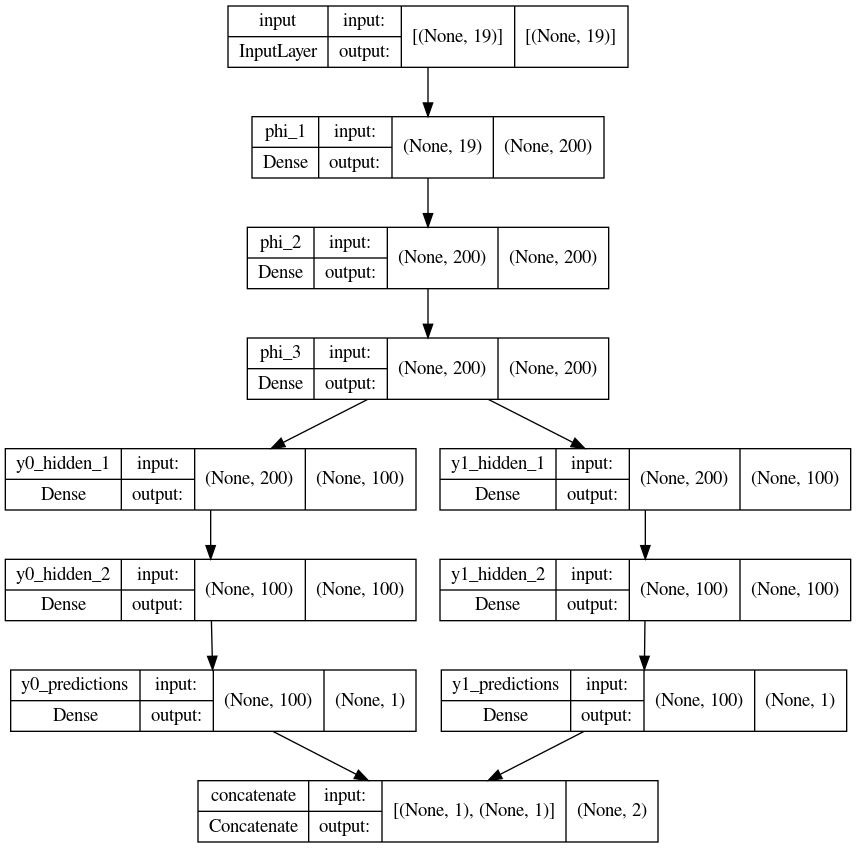

In [3]:
tarnet_model=make_tarnet(19,.01)
#tarnet_model=make_tarnet(25,.01) for example, in our case we have 11 variables (ToDo: change with new feature set)

print(tarnet_model.summary())
tf.keras.utils.plot_model(tarnet_model, show_shapes=True, show_layer_names=True, to_file='tarnet.png')

from IPython.display import Image # this just Jupyter notebook stuff
Image(retina=True, filename='tarnet.png')

## Specifying the loss function
There are again at least four different ways to specify loss functions in Tensorflow2: if you have a standard loss there are built-in options, you can specify them as custom functions, custom objects, or build them into custom layers of your network. Here we've written a function.

 Note that we compute $\mathcal{L}(Y(0),h(\Phi(X),0))$ and $\mathcal{L}(Y(1),h(\Phi(X),1))$ separately and just add them to get the whole loss. Tensorflow will apply the gradients appropriately to the different outcome and representation layers.

In [4]:
# every loss function in TF2 takes 2 arguments, a vector of true values and a vector predictions
def regression_loss(concat_true, concat_pred):
    #computes a standard MSE loss for TARNet
    y_true = concat_true[:, 0] #get individual vectors
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    #Each head outputs a prediction for both potential outcomes
    #We use t_true as a switch to only calculate the factual loss
    loss0 = tf.reduce_sum((1. - t_true) * tf.square(y_true - y0_pred))
    loss1 = tf.reduce_sum(t_true * tf.square(y_true - y1_pred))
    #note Shi uses tf.reduce_sum for her losses instead of tf.reduce_mean.
    #They should be equivalent but it's possible that having larger gradients accelerates convergence.
    #You can always try changing it!
    return loss0 + loss1

## Data

In [5]:
import pandas as pd
df = pd.read_csv("bpi2017_final.csv")

In [6]:
df.head()

,case:concept:name,NumberOfOffers,Action,org:resource,concept:name,EventOrigin,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,CreditScore,OfferedAmount,treatedCase,caseSuccesful,treatmentSuccess,offerNumber,offerSuccess,treatmentOffer,timeApplication,weekdayApplication
0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,651433.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,2.0
1,0.0,1.0,4.0,0.0,8.0,0.0,1.0,651434.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.061,2.0
2,0.0,1.0,0.0,0.0,22.0,2.0,3.0,651435.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.290,2.0
3,0.0,1.0,1.0,0.0,22.0,2.0,6.0,651437.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,66.613,2.0
4,0.0,1.0,0.0,0.0,21.0,2.0,3.0,651438.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,66.620,2.0


In [7]:
feature_names = ['NumberOfOffers', 'Action', 'org:resource',
       'concept:name', 'EventOrigin', 'lifecycle:transition', 'time:timestamp',
       'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'CreditScore', 'OfferedAmount', 'offerNumber','timeApplication', 'weekdayApplication']

In [8]:
#treatment (x), potential outcome (y), and covariates (v)
# t_treatment = struct_data['treatment'].values
y_outcome = df['offerSuccess'].values
x_feature = df[feature_names].values
t_treatment = np.array([np.array([value]) for value in df['treatmentOffer']])
# y_outcome = np.array([np.array([value]) for value in struct_data_type['successful']])
#x_feature = np.array([np.array([value]) for value in df[feature_names]])

In [9]:
x_feature_shape=x_feature.reshape(-1,1) #we're just padding one dimensional vectors with an additional dimension
y_outcome_shape=y_outcome.reshape(-1,1)

#rescaling y between 0 and 1 often makes training of DL regressors easier
df['y_scaler'] = StandardScaler().fit(y_outcome_shape)
# struct_data_type['y_outcome'] = struct_data_type['y_scaler'].transform(y_outcome_shape)
df['ys'] = StandardScaler().fit_transform(y_outcome_shape)
ys = np.array([np.array([value]) for value in df['ys']])

# Training and Fitting the Model


<details><summary>A brief spoiler about training neural networks if you've never done so before.</summary>

When you use other types of machine learning models, optimization of the model parameters is typically done for you under the hood and you simply wait for training to finish. In contrast, neural networks have so many parameters that optimization becomes an art.

Rather than training on the whole training dataset at once, neural networks are trained on mini-batches of dozens to a few hundred examples. This is a compromise between applying error gradients from a single example (computationally expensive) and using the whole training dataset (expensive in terms of memory; may not work as well for losses that are not perfectly convex). The error gradient is applied to the network parameters after each mini-batch. A complete iteration through all mini-batches in the training set is called an **epoch.**

After each epoch we run prediction on the entire validation set. While there are a number of regularization techniques used in DL to prevent overfitting (norms, dropout, batch normalization), the most important is **early stopping.** To prevent overfitting, we wish to stop training after several consecutive epochs where the validation loss has failed to improve. The number of epochs to wait after early stopping is often called a *patience* hyperparameter.

The proportion of the gradient the optimizer backpropagates to the parameters is called the **learning rate.** A learning rate that is too small takes a long time to train. A learning rate that is too large will overshoot optima. Learning rate schedulers are used to adaptively slow the learning rate as you get closer to an optimum.

---

</details>


Shi uses the builtin Keras `.fit` infrastructure for training the model which makes things super easy. There are a lot of hyperparameter choices here, but I won't dwell on them because hyperparameter selection will be covered in the next tutorial.

 In this example we use stochastic gradient descent to optimize the model with an initial learning rate of 1E-4 and momentum of .9. You can also try other optimizers (e.g., ADAM). **While you should experiment with different learning rates, I recommend having a conservative (smaller) learning rate because we really want our estimator to be unbiased.**

 To avoid overfitting, we stop training deep learning models when the validation loss stops improving. In Tensorflow the `EarlyStopping` callback automatically stops training after a number of epochs with no improvement on the validation loss (`patience` parameter). The `ReduceLROnPlateau` adaptively lowers the learning rate of the optimizer as we approach validation loss plateaus so that the optimizer does not overshoot the current optimum.

We use a mini-batch size of 64. Other papers have recommmended batch sizes up to 200 with this dataset. **The batch size is an important consideration for these causal inference architectures because you really want to make sure each mini-batch has both treatment and control examples for the representation layers.** This is obviously less of a problem for datasets with high proportions of treated units.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import SGD


val_split=0.2
batch_size=20000
verbose=1
i = 0
tf.random.set_seed(i)
np.random.seed(i)
yt = np.concatenate([ys, t_treatment], 1) #we'll use both y and t to compute the loss


sgd_callbacks = [
        TerminateOnNaN(),
        EarlyStopping(monitor='val_loss', patience=80, min_delta=0.),
        #40 is Shi's recommendation for this dataset, but you should tune for your data
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                          min_delta=0., cooldown=0, min_lr=0),
    ]
#optimzier hyperparameters
sgd_lr = 1e-3 #1e-5
momentum = 0.9
tarnet_model.compile(optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True),
                    loss=regression_loss,
                    metrics=regression_loss)

tarnet_model.fit(x=x_feature,y=yt,
                callbacks=sgd_callbacks,
                validation_split=val_split,
                epochs=300,
                batch_size=batch_size,
                verbose=verbose)
print("DONE!")

Epoch 1/300
48/48 [==============================] - 1s 10ms/step - loss: nan - regression_loss: nan - val_loss: nan - val_regression_loss: nan - lr: 0.0010
DONE!


# Estimating the ATE/CATE

Now we can do inference on either the whole dataset or a heldout testing sample. For simplicity, we just use the whole dataset here.

We'll also plot our CATE estimates against the the true cates from the simulation.

In [11]:
import pandas as pd

concat_pred=tarnet_model.predict(x_feature)
#dont forget to rescale the outcome before estimation!
y0_pred = df['y_scaler'].inverse_transform(concat_pred[:, 0].reshape(-1, 1))
y1_pred = df['y_scaler'].inverse_transform(concat_pred[:, 1].reshape(-1, 1))
cate_pred=y1_pred-y0_pred
#cate_true=data['mu_1']-data['mu_0'] #Hill's noiseless true values
ate_pred=tf.reduce_mean(cate_pred)
print("Estimated ATE: ", ate_pred.numpy(),'\n\n')

print("Individualized CATE Estimates: BLUE")
print(pd.Series(cate_pred.squeeze()).plot.kde(color='blue'))
#print("Individualized CATE True: Green")
#print(pd.Series(cate_true.squeeze()).plot.kde(color='green'))

#print("\nError CATE Estimates: RED")
#print(pd.Series(cate_pred.squeeze()-cate_true.squeeze()).plot.kde(color='red'))


AttributeError: 'Series' object has no attribute 'inverse_transform'

While our estimates have a broader spread than the real values, we haven't done any hyperparameter optimization yet so we can definitely do better. That's the focus of the next tutorial.

Of course we can also break down these heterogeneous treatment effects to see if we can find any interesting patterns using, for example, Google's [Facet Dive](https://pair-code.github.io/facets/). This is just demonstrative since our covariates are meaningless in the simulation, but it's still cool. The Facet Dive is now built into TensorBoard.

In [ ]:
#@title Explore Heterogeneity Using the Facet Dive

data['cate_pred']=cate_pred
facet_df=pd.DataFrame(data['x'])
facet_df['t']=data['t']
facet_df['y']=data['y']
facet_df['cate_pred']=data['cate_pred']


# Display the Dive visualization for the training data.
from IPython.core.display import display, HTML

jsonstr = facet_df.to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))